In [2]:
# importing all important libraries
import math
import keras
import numpy as np
import pandas as pd
from keras import layers
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint, TensorBoard
import absl.logging
from keras.constraints import NonNeg
from sklearn.metrics import roc_curve, precision_recall_curve
absl.logging.set_verbosity(absl.logging.ERROR)
import glob
import os

In [3]:
path = '../input/dataset7'
all_files = glob.glob(path + "/*.csv")
all_files

['../input/dataset7/UNSW_IoT_Full5pc_1.csv',
 '../input/dataset7/UNSW__IoT__Full5pc_2.csv',
 '../input/dataset7/UNSW__IoT_Full5pc_4.csv',
 '../input/dataset7/UNSW_IoT_Full5pc_3.csv']

In [4]:
all_files = glob.glob(path + "/*.csv")
all_files

['../input/dataset7/UNSW_IoT_Full5pc_1.csv',
 '../input/dataset7/UNSW__IoT__Full5pc_2.csv',
 '../input/dataset7/UNSW__IoT_Full5pc_4.csv',
 '../input/dataset7/UNSW_IoT_Full5pc_3.csv']

In [5]:
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, low_memory=False)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [6]:
# Getting count of attack column's labels
df['subcategory'].value_counts()

subcategory
UDP                  1981230
TCP                  1593180
Service_Scan           73168
OS_Fingerprint         17914
HTTP                    2474
Normal                   477
Keylogging                73
Data_Exfiltration          6
Name: count, dtype: int64

In [7]:
# Segregating columns based on thier types

columns = df.columns.tolist()

# categorical columns
nominal = [col for col in columns if df[col].dtype == 'object']

# ordinal columns
discrete = [col for col in columns if df[col].dtype == 'int64']

# continuous columns
continuous = [col for col in columns if df[col].dtype == 'float']

# dissect the dataframe by column types
df_nominal = df.select_dtypes(include=['object'])
df_discrete = df.select_dtypes(include=['int64'])
df_continuous = df.select_dtypes(include=['float'])

# enumerate nominal categories using integers
df_categorical = df.select_dtypes(include=['int8', 'int16'])

# Making a sample of balanced subset data to use it later if required
df_class_0 = df[df['attack'] == 0]
df_class_1 = df[df['attack'] == 1]
df_class_1_subset = df_class_1.sample(n=447, random_state=100)
df_balanced = pd.concat([df_class_1_subset, df_class_0])

In [8]:
le = LabelEncoder()
for _col in nominal:
    print(f'before enumerating: {_col}', df[_col].value_counts(), '\n', sep='\n')
    try:
        df[_col] = le.fit_transform(df[_col])
    except TypeError:
        df[_col] = le.fit_transform(df[_col].astype(str))
    print(f'after enumerating: {_col}', df[_col].value_counts(), '\n', sep='\n')

before enumerating: flgs
flgs
e        2293445
e s      1245171
e g        94344
eU         34599
e *          816
e d          137
e &            5
e   t          4
e  D           1
Name: count, dtype: int64


after enumerating: flgs
flgs
0    2293445
7    1245171
6      94344
8      34599
4        816
5        137
3          5
1          4
2          1
Name: count, dtype: int64


before enumerating: proto
proto
udp          1996437
tcp          1662812
icmp            9052
arp              213
ipv6-icmp          8
Name: count, dtype: int64


after enumerating: proto
proto
4    1996437
3    1662812
1       9052
0        213
2          8
Name: count, dtype: int64


before enumerating: saddr
saddr
192.168.100.147              950966
192.168.100.148              923290
192.168.100.150              890262
192.168.100.149              890146
192.168.100.3                  8281
192.168.100.5                  5118
192.168.100.6                   327
192.168.100.7                    43
192.16

In [9]:
df

,pkSeqID,stime,flgs,flgs_number,proto,proto_number,saddr,sport,daddr,dport,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,1.528089e+09,0,1,3,1,1,44407,21,6650,...,1.127040,96,75,1.133720,1.129970,770,602,1,1,1
1,2,1.528089e+09,0,1,0,2,12,0,10,0,...,15267.200000,1,2,0.005142,0.005142,2,6,1,1,1
2,3,1.528089e+09,0,1,3,1,1,44409,21,6650,...,1.127040,96,75,1.135100,1.129970,770,602,1,1,1
3,4,1.528089e+09,0,1,3,1,1,44411,21,6650,...,1.127040,96,75,1.135140,1.129970,770,602,1,1,1
4,5,1.528089e+09,0,1,3,1,1,44413,21,6650,...,1.127040,96,75,1.135260,1.129970,770,602,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668517,2999996,1.528099e+09,0,1,4,3,1,58019,16,6650,...,0.955877,100,52,1.098270,0.955877,1308,780,1,0,7
3668518,2999997,1.528099e+09,0,1,4,3,1,58030,16,6650,...,0.955877,100,52,1.098270,0.955877,1308,780,1,0,7
3668519,2999998,1.528099e+09,0,1,4,3,1,58041,16,6650,...,0.955877,100,52,1.098270,0.955877,1308,780,1,0,7
3668520,2999999,1.528099e+09,0,1,4,3,1,58052,16,6650,...,0.955877,100,52,1.098270,0.955877,1308,780,1,0,7


In [10]:
df.corr()

,pkSeqID,stime,flgs,flgs_number,proto,proto_number,saddr,sport,daddr,dport,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
pkSeqID,1.000000,-0.243073,-0.274427,-0.254161,0.237317,0.273690,0.005566,0.007401,-0.590200,-0.224795,...,0.116417,0.344897,-0.034067,0.053604,0.057567,0.275888,0.160856,-0.018767,-0.478614,0.130571
stime,-0.243073,1.000000,0.061441,-0.038804,0.180173,0.070712,-0.080864,0.007826,0.026976,0.830622,...,-0.427939,0.095941,0.122517,-0.199616,-0.211940,0.137739,0.154239,0.075162,-0.640137,0.452878
flgs,-0.274427,0.061441,1.000000,0.718275,-0.767601,-0.803181,-0.109793,-0.021071,0.027792,0.054831,...,-0.027721,-0.007546,-0.068004,-0.016105,-0.016396,-0.446892,-0.429715,0.008639,-0.103009,-0.659682
flgs_number,-0.254161,-0.038804,0.718275,1.000000,-0.488383,-0.512343,0.019017,-0.002686,-0.004077,-0.025131,...,0.023426,-0.108676,-0.102976,0.002549,0.005050,-0.298687,-0.279031,0.005521,0.058681,-0.459878
proto,0.237317,0.180173,-0.767601,-0.488383,1.000000,0.940239,-0.046550,0.022225,0.124338,0.195264,...,-0.036549,0.012072,0.081839,-0.020218,-0.024496,0.575714,0.560482,0.001449,-0.012266,0.892094
proto_number,0.273690,0.070712,-0.803181,-0.512343,0.940239,1.000000,0.029158,-0.007922,0.077589,0.034446,...,-0.037283,-0.066941,0.052470,-0.021195,-0.025422,0.567656,0.554534,-0.007329,0.055794,0.871424
saddr,0.005566,-0.080864,-0.109793,0.019017,-0.046550,0.029158,1.000000,-0.007786,-0.440493,-0.119262,...,0.013769,-0.074879,-0.038904,0.010006,0.010449,-0.076650,-0.083931,-0.026496,0.068329,-0.027672
sport,0.007401,0.007826,-0.021071,-0.002686,0.022225,-0.007922,-0.007786,1.000000,0.006216,0.022656,...,0.012448,0.013232,-0.002529,0.005191,0.010963,-0.018001,-0.022310,-0.001217,0.001331,-0.002508
daddr,-0.590200,0.026976,0.027792,-0.004077,0.124338,0.077589,-0.440493,0.006216,1.000000,0.075878,...,-0.019932,-0.259323,0.044876,-0.010496,-0.011235,-0.136886,-0.063728,-0.147924,0.513200,0.080316
dport,-0.224795,0.830622,0.054831,-0.025131,0.195264,0.034446,-0.119262,0.022656,0.075878,1.000000,...,-0.365127,0.119636,0.135833,-0.171444,-0.168446,0.126090,0.140610,0.039805,-0.519266,0.385963


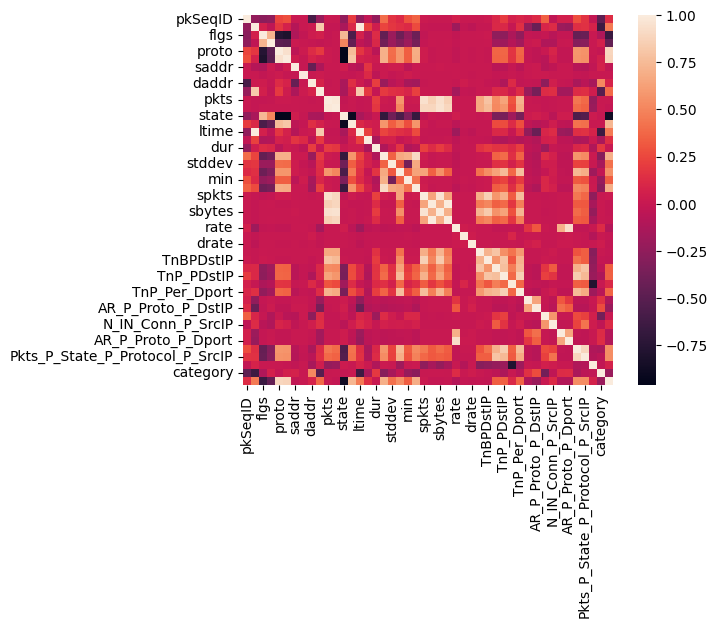

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Assuming df is your DataFrame
dataplot = sns.heatmap(df.corr())

# Adjust the aspect ratio of the figure
plt.gca().set_aspect('equal', adjustable='box')

# Specify the directory where you want to save the image
output_directory = "/kaggle/working/"

# Save the plotted image with high quality
output_file = os.path.join(output_directory, 'correlation_heatmap.png')
dataplot.figure.savefig(output_file, dpi=400, bbox_inches='tight')  # Adjust dpi for desired quality

# Display the heatmap
plt.show()

In [12]:
# sorting columns based on the correlation they have with attack column

corr_df = df.corr()['attack']
corr_df = pd.DataFrame(corr_df)
corr_df['attack'] = abs(pd.DataFrame(corr_df)['attack'])
corr_df.sort_values(by=['attack'], ascending=False)

,attack
attack,1.000000
TnP_PerProto,0.786449
TnBPSrcIP,0.286339
TnBPDstIP,0.257277
spkts,0.254066
pkts,0.232678
TnP_PSrcIP,0.229447
sbytes,0.228567
bytes,0.209617
TnP_PDstIP,0.203535


In [14]:
cloned_df = df.copy()
y_df = cloned_df['attack']
x_df = cloned_df

In [15]:
# keeping only most correlated columns and removing those which have less than 1 percent or 0.01 correlation

reduced_columns = list(corr_df[corr_df['attack'] > 0.01].index)
print(reduced_columns)
x_df = x_df[reduced_columns]
x_df.shape

['pkSeqID', 'stime', 'saddr', 'daddr', 'dport', 'pkts', 'bytes', 'state', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'srate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'attack', 'category', 'subcategory']


(3668522, 33)

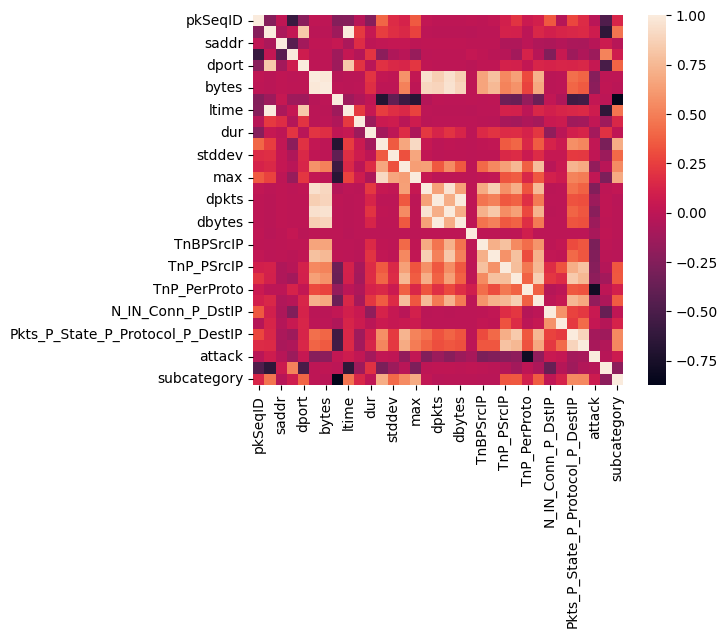

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Assuming df is your DataFrame
dataplot = sns.heatmap(x_df.corr())

# Adjust the aspect ratio of the figure
plt.gca().set_aspect('equal', adjustable='box')

# Specify the directory where you want to save the image
output_directory = "/kaggle/working/"

# Save the plotted image with high quality
output_file = os.path.join(output_directory, 'correlation_heatmap_after.png')
dataplot.figure.savefig(output_file, dpi=400, bbox_inches='tight')  # Adjust dpi for desired quality

# Display the heatmap
plt.show()

In [23]:
x_df

,pkSeqID,stime,saddr,daddr,dport,pkts,bytes,state,ltime,seq,...,TnP_PDstIP,TnP_PerProto,TnP_Per_Dport,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,1.528089e+09,1,21,6650,8,1980,8,1.528089e+09,9,...,770,772,772,96,75,770,602,1,1,1
1,2,1.528089e+09,12,10,0,2,120,1,1.528089e+09,10,...,2,8,8,1,2,2,6,1,1,1
2,3,1.528089e+09,1,21,6650,8,2126,8,1.528089e+09,11,...,770,772,772,96,75,770,602,1,1,1
3,4,1.528089e+09,1,21,6650,8,2024,8,1.528089e+09,12,...,770,772,772,96,75,770,602,1,1,1
4,5,1.528089e+09,1,21,6650,8,2319,8,1.528089e+09,13,...,770,772,772,96,75,770,602,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668517,2999996,1.528099e+09,1,16,6650,15,900,4,1.528099e+09,109218,...,1308,1308,1308,100,52,1308,780,1,0,7
3668518,2999997,1.528099e+09,1,16,6650,15,900,4,1.528099e+09,109219,...,1308,1308,1308,100,52,1308,780,1,0,7
3668519,2999998,1.528099e+09,1,16,6650,15,900,4,1.528099e+09,109220,...,1308,1308,1308,100,52,1308,780,1,0,7
3668520,2999999,1.528099e+09,1,16,6650,15,900,4,1.528099e+09,109221,...,1308,1308,1308,100,52,1308,780,1,0,7


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = x_df.drop("attack", axis=1).values  # Features
y = x_df["attack"].values  # Target variable

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)